<a href="https://colab.research.google.com/github/BKeim-UB/SW_VERT_PROFILES/blob/main/TGSD_FROM_PROFILES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COMPUTE VERTICAL PROFILES AND TGSD

This script computes vertical profiles for the velocity and volumetric concentration of particles given depth-averaged values in terms of:

- flow thickness $h$;
- depth-averaged velocity $u_{avg}$ or depth-averaged mass flux $(\rho u)_{avg}$;
- total depth-averaged volumetric fraction of particles $\alpha_s^{tot}$;
- TGSD parameters (mean size $\mu$ and standard deviation $\sigma$ in phi scale.

The density of solid particles changes linearly in the phi scale between a minimum a maximum value, defined by additional input parameters:
$$
\rho(\phi) = \begin{cases}
    \rho_1 & \text{if } \phi<\phi_1 \\
    \rho_1 + \frac{\phi - \phi1}{\phi_2 - \phi1} \rho_2 & \text{if } \phi_1\leq \phi\leq \phi_1 \\
    \rho_2 & \text{if } \phi>\phi_2
\end{cases}
$$

In addition, density and kinematic visocisty of the gas and gravitational acceleration should be provided.

These parameters are defined in the next code block.

In [ ]:
%reset -f

# flow thickness [m]
h = 145.50

# depth averaged velocity [m/s]
u_avg = 1.15e2
# u_avg = 75.23557876694905
# u_avg = 66.93331999075606

# depth-averaged u(z)*rhom(z)  [kg/(m2 s)]
# uRho_avg = 894.409442921292

# Total volumetric fraction of solid particles
alphas_tot = 1.41e-3


# depth-averaged mixture density [kg/m3]
# rhom = 17.888

# The TGSD is defined by a normal distribution in the phi scale
# Parameters of the normal TGSD
mu = 1
sig = 1.0

# Particle Densities parameters:
phi1 = -2
rho1 = 1750.0
phi2 = 1
rho2 = 1750.0

# Classes of particle sizes
phi_min = 2
phi_max = 2
nsolid = 1

# Pressure [Pa]
pres = 101300

# Specific gas constant of gas mixture (units: J kg-1 K-1)
sp_gas_const = 287.051

# Mixture temperature [k]
temp = 709

# gas kinematic viscosity [m2/s]
kin_visc = 1.48e-5

# gravitational acceleration [m/s2]
grav = 9.81

# Von Karman constant
k = 0.4

# friction coefficient
friction_coeff = 0.003

# substrate roughness [m]
k_s = 1.5

# ratio of momentum and mass diffusivity (Schmidt number)
beta_sc = 1.0

# parameters for the convergence of the iterative solution procedure
rel_tol = 1.e-10
abs_tol = 1.e-8

In [ ]:
# check on input
if ('uRho_avg' in locals()) and ('u_avg' in locals()):

    print('Please specify ONLY one among u_avg or uRho_avg')

elif 'u_avg' in locals():

    print('Using u_avg')

elif 'uRho_avg' in locals():

    print('Using uRho_avg')

else:

    print('Please specify one among u_avg or uRho_avg')

if ('rhom' in locals()) and ('alphas_tot' in locals()):

    print('Please specify ONLY one among rhom or alphas_tot')

elif 'rhom' in locals():

    print('Using rhom')

elif 'alphas_tot' in locals():

    print('Using alphas_tot')

else:

    print('Please specify one among rhom or alphas_tot')


Using u_avg
Using alphas_tot


Several Python packages are needed.

In [ ]:
# Import Libraries

import scipy.special as sc
from mpmath import * ; mp.dps = 15 ; mp.pretty = True
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import lambertw # imports the lambert function and returns complex result
from scipy import integrate        # allows us to use the exponential integral function
from scipy.stats import norm
from google.colab import files


The function *Settling_Velocity()* in the following block takes the inputs:

• rhos - The density of each solid class $\left(\frac{kg}{m^3}\right)$

• rhog - The density of the gas phase $\left(\frac{kg}{m^3}\right)$

• diam - The diameter of each class of particles (meters)

• grav - The gravitational Constant - 9.81 $\left(\frac{m}{s^2}\right)$

• kin_visc - The Kinematic Viscosity of gas (units)


If the density of the solid phase is less than the gasous phase, a check is included which sets the settling velocity to 0.

Otherwise, the settling velocity is computed via the following function:

The settling velocity, as a function of the size of the particles, satisfy the following relationship:

$$
    v_s(d_s) = \sqrt{\frac{4}{3} \frac{d_s g}{C_D({\rm Re})} \left(\frac{\rho_s-\rho_a}{\rho_a}\right)}.
$$

Please note that the drag coefficient $C_D$ is a function of the Reynolds number $Re== \frac{d_s v_s}{\nu}$, and thus of the settling velocity, through the following equation.

$$
C_D({\rm Re}) = \frac{24}{\rm Re} \left( 1 + 0.15 {\rm Re}^{0.687} \right)
$$

For this reason, the following function adopts an iterative procedure to compute the settling velocity.

In [ ]:
# Settling Velocity

def settling_velocity(rhos, rhog, diam, grav, kin_visc):

    inv_sqrt_C_D = 1.0
    settl_vel = np.zeros_like(rhos)
    for i in range(0, len(phi)):

        if rhos[i] <= rhog:
            settl_vel[i] = 0.0

        else:

            const_part = np.sqrt(0.75 * (rhos[i] / rhog - 1.0) * diam[i] *
                                 grav)
            settl_vel[i] = const_part * inv_sqrt_C_D
            Rey = diam[i] * settl_vel[i] / kin_visc

            for j in range(20):
                inv_sqrt_C_D = np.sqrt(Rey / (24.0 *
                                              (1.0 + 0.15 * Rey**0.687)))
                settl_vel[i] = const_part * inv_sqrt_C_D
                Rey = diam[i] * settl_vel[i] / kin_visc

    return settl_vel

The next function compute the relative mass fractions of the solid classes from the parameters of the size distribution.

In [ ]:
# Total Grain Size Distribution
def TGSD(mu, sig, phi):
    n_bins = len(phi)
    xs = norm.cdf(0.5 * (phi[0:len(phi) - 1] + phi[1:len(phi)]), mu, sig)
    xs = np.append(xs, [1])
    xs[1:len(phi)] = np.diff(xs)

    return xs

This function compute the density of a class of particles, given the size in the phi scale.

$$
\rho(\phi) = \begin{cases}
    \rho_1 & \text{if } \phi<\phi_1 \\
    \rho_1 + \frac{\phi - \phi1}{\phi_2 - \phi1} \rho_2 & \text{if } \phi_1\leq \phi\leq \phi_1 \\
    \rho_2 & \text{if } \phi>\phi_2
\end{cases}
$$

In [ ]:
# Particle Density Computation
def part_dens(phi, phi1, rho1, phi2, rho2):

    rhos = rho1 * (phi < phi1) + (phi >= phi1) * (
        rho1 + (rho2 - rho1) * np.minimum(1.0, (phi - phi1) / (phi2 - phi1)))

    return rhos

In [ ]:
# Compute average profiles

def avg_profiles_mix(h, settl_vel, k, friction_coeff, rhoalpha_avg, u_guess,
                     beta_sc, h0, b, u_coeff, u_rel0, rhos, rhog):

    u_star = u_guess * np.sqrt(friction_coeff)
    Pn = settl_vel / (k * u_star)
    nsolid = len(settl_vel)
    rho_u_alphas = np.zeros(nsolid)
    rhoalphas_int = np.zeros(nsolid)

    for i in range(len(settl_vel)):

        d_bl = h0
        # epsilon_s = beta_sc * u_star * d_bl / (6.0 * (k * d_bl + k_s / 10.0))
        epsilon_s = beta_sc * u_star * k * ((d_bl/6.0) + (k_s / 60.0))
        a = -(k * u_star * Pn[i]) / epsilon_s

        # average-integral of c(z):
        # - exp(a*z) between 0 and h0
        # - exp(a*h0) between h0 and h
        int_ = ((np.exp(a * h0) - 1.0) / a + np.exp(a * h0) * (h - h0)) / h

        normalizing_coeff = 1.0 / int_

        # normalizing_coeff*c(z) has depth-average = 1

        # value of the normalized profile at h0
        # this is the true concentration at h0 divided by
        # the depth-averaged concentration
        alphas_rel0 = normalizing_coeff * np.exp(a * h0)

        y = h0
        int_h0 = (np.exp(a * y) * np.log(b * y + 1.0) +
                  np.exp(-a / b) * sc.exp1(-a * (y + 1.0 / b))) / a

        y = 0
        int_0 = (np.exp(a * y) * np.log(b * y + 1.0) +
                 np.exp(-a / b) * sc.exp1(-a * (y + 1.0 / b))) / a

        int_def = u_coeff * np.sqrt(friction_coeff) / \
            k * normalizing_coeff * (int_h0-int_0)

        rho_u_alphas[i] = rhoalpha_avg[i] * u_guess * \
            (int_def + (h - h0) * alphas_rel0 * u_rel0) / h

    rhom_avg = rhog + sum((rhos - rhog) / rhos * rhoalpha_avg)
    uRho_avg_new = (u_guess * rhog + sum((rhos - rhog) / rhos * rho_u_alphas))

    return rhom_avg, uRho_avg_new

# Code and Outputs

In [ ]:
# Numpy array of phi solid classes
phi = np.linspace(phi_min, phi_max, nsolid)

# Relative mass fractions of the particle classes (sum=1)
xs_rel = TGSD(mu, sig, phi)

# Density of the solid classes
rhos = part_dens(phi, phi1, rho1, phi2, rho2)

# Average density of solid particles [kg/m3]
rhos_tot = 1.0 / (sum(xs_rel / rhos))

# Particles diameters [m]
diam = (1.0e-3) * 2**(-phi)

for i in range(0, nsolid):
    print('Particles diameter d', '[', i + 1, '] in meters',
          '             =', round(diam[i], 15))


# Gas density [kg/m3]
rhog = pres / ( sp_gas_const * temp )

print('Gas density (kg/m3)',rhog)

# Particles settling velocities [m/s]
settl_vel = settling_velocity(rhos, rhog, diam, grav, kin_visc)

for i in range(0, nsolid):
    print('Settling velocity for class', '[', i + 1, ']',
          '             =', round(settl_vel[i], 15))

if 'rhom' in locals():

    # total volume fraction of solid in the gas-solid mixture
    alphas_tot = ( rhom - rhog ) / ( rhos_tot - rhog )

    print('Total solid volume fraction computed from rhom',
      '                   =', alphas_tot)

else:

    # Gas-particles mixture density [kg/m3]
    rhom = alphas_tot * rhos_tot + (1.0 - alphas_tot) * rhog

    print('Mixture density computed from mass fractions (kg/m3)',
      '                   =', rhom)

# Total solid mass fraction [kg/kg]
xs_tot = alphas_tot * rhos_tot / rhom

# Solid mass fraction of solid classes in the mixture [kg/kg]
xs = xs_rel * xs_tot


# Depth-averaged volumetric fractions
alpha_avg = xs / rhos * rhom

for i in range(0, nsolid):
    print('Depth-averaged alpha(1) computed from xs', '[', i + 1, ']',
          '             =', round(alpha_avg[i], 15))

print(
    'Total solid depth-averaged volume fraction computed from mass fractions =',
    sum(alpha_avg))

# this is the depth-averaged value of rhos*alpha(z), which is equal to the
# depth-averaged  value  of xs*rhom(z). So it is the conservative variable
# used for the solid mass divided by h.
rhoAlpha_avg = rhos * alpha_avg


Particles diameter d [ 1 ] in meters              = 0.00025
Gas density (kg/m3) 0.49774183667887506
Settling velocity for class [ 1 ]              = 1.781011116538942
Mixture density computed from mass fractions (kg/m3)                    = 2.9645400206891575
Depth-averaged alpha(1) computed from xs [ 1 ]              = 0.00141
Total solid depth-averaged volume fraction computed from mass fractions = 0.0014099999999999998


The thickness of the turbulent boundary layer and the presence (or absence) of a free-stream region depends on several factors. It can be shown that there exists a critical flow thickness $H_{crit}$, above which a free-stream region is required, while below the critical thickness the velocity has a logarithmic profile for the entire flow thickness. This critical thickness is given by

$$
H_{crit} = \frac{k_s}{30} \left( \frac{a}{{W}(-ae^{-a})} - 1 \right),
$$

where $a = \frac{\kappa}{\sqrt{C_f}}$ and ${W}$ is the Lambert function.

It is easier to work with a non-dimensional height $h^{rel}=\frac{h}{k_s}$, which also results in a non-dimensional critical thickness:
$$
H_{crit}^{rel} = \frac{1}{30} \left( \frac{a}{{W}(-ae^{-a})} - 1 \right).
$$

In [ ]:
# H_crit is a critical thickness above  which there is a constant free stream
# velocity. Below  H_crit  we  only  have  the  log  profile. H_crit is a
# function of k, k_s and friction_coeff only. H_crit_rel  is  the
# non-dimensional crtitical thickness, which depends on k and the friction
# coefficient only

# The profile parameters depend on h/k_s, not on the absolute value of h.
h_rel = h / k_s

a = k / np.sqrt(friction_coeff) + 1.0
print('a',a,k,friction_coeff)
H_crit_rel = np.real(1.0 / 30.0 * (-a / lambertw(-a * np.exp(-a)) - 1.0))
print('Critical thickness (meters)    =', round(H_crit_rel * k_s, 13))

a 8.302967433402216 0.4 0.003
Critical thickness (meters)    = 201.3259584644918


We define now the relative thickness of the turbulent boundary layer which is:


In [ ]:
if (h_rel > H_crit_rel):

    # we search for h0_rel such that the average integral between 0 and
    # h_rel is equal to 1. For h_rel > H_crit_rel  this  integral is the
    # sum of  two  pieces:  integral  between  0  and h0_rel of the log
    # profile integral between h0_rel and h_rel of  the costant profile

    a = h_rel * k / np.sqrt(friction_coeff)
    b = 1.0 / 30.0 + h_rel
    c = 30.0

    # solve b*log(c*z+1)-z=a for z
    d = a / b - 1.0 / (b * c)

    h0_rel = np.real(-b * lambertw(-np.exp(d) / (b * c)) - 1.0 / c)
    u_coeff = 1.0

else:

    # when h_rel <= H_crit_rel we have only the log profile and we have to
    # rescale it in order to have the integral between o and h_rel equal to 1
    # The factor used to scale the velocity is u_coeff

    h0_rel = h_rel
    u_coeff = k / np.sqrt(friction_coeff) / (
        (1 + 1 / (30 * h_rel)) * np.log(30.0 * h_rel + 1.0) - 1.0)

h0 = h0_rel * k_s

print('Boundary layer thickness (m) = ',h0)

b = 30.0 / k_s
u_rel0 = u_coeff * np.sqrt(friction_coeff) / k * np.log(b * h0 + 1.0)

Boundary layer thickness (m) =  145.5


In [ ]:
if 'uRho_avg' in locals():

    # search convergence of u_avg
    n = 200

    u_avg_guess = uRho_avg / rhom
    x0 = u_avg_guess

    # loop to compute the average velocity from average rho*alpha and average
    # uRho ( = 1/h*int( u*rhog*alphag + sum[u*rhos(i)*alphas(i)] ) )
    print()
    #     avg_profiles_mix function returns ([rhom_avg,uRho_avg_new])

    for i in range(0, n):

        x0 = u_avg_guess

        rhom_avg, uRho_avg_new = avg_profiles_mix(h, settl_vel, k,
                                                  friction_coeff, rhoAlpha_avg,
                                                  u_avg_guess, beta_sc, h0, b,
                                                  u_coeff, u_rel0, rhos, rhog)

        u_avg_new = u_avg_guess * uRho_avg / (uRho_avg_new)

        x1 = u_avg_new

        rhom_avg, uRho_avg_new = avg_profiles_mix(h, settl_vel, k,
                                                  friction_coeff, rhoAlpha_avg,
                                                  u_avg_new, beta_sc, h0, b,
                                                  u_coeff, u_rel0, rhos, rhog)

        u_avg_new = u_avg_new * uRho_avg / (uRho_avg_new)

        x2 = u_avg_new

        if (x1 != x0):
            # OPTIONAL: Computes an approximation of |f'(fixedPoint)|, which is
            # denoted by lambda
            lambda_ = abs((x2 - x1) / (x1 - x0))

        denominator = (x2 - x1) - (x1 - x0)

        # To avoid greatly increasing error, do not divide by too small of a
        # number
        if (abs(denominator) < 0.1 * abs_tol):
            print('')
            print('                     –––––––                      ')
            print('****************** Ending Loop *******************')
            print('******** WARNING: denominator is too small *******')
            break  # Leave the loop

        aitkenX = x2 - ((x2 - x1)**2) / denominator

        u_avg_new = aitkenX

        if (abs(u_avg_guess - u_avg_new) / u_avg_guess <
                rel_tol) or (abs(u_avg_guess - u_avg_new) < abs_tol):
            u_avg_guess = u_avg_new

        u_avg_guess = u_avg_new

        print('Iteration #', i + 1, '–––> u_guess =', round(u_avg_new, 14),
              ' m/s')

    print('                     –––––––                      ')
    print('                                                         ')
    print('Total Iterations           = ', i)
    print('u_final                    = ', round(u_avg_new, 13), 'm/s')
    print('Depth-averaged rho         = ', round(rhom_avg, 12), 'kg/m3')

    # average velocity
    u_avg = u_avg_new

rhom_avg, uRho_avg = avg_profiles_mix(h, settl_vel, k, friction_coeff,
                                      rhoAlpha_avg, u_avg, beta_sc, h0, b,
                                      u_coeff, u_rel0, rhos, rhog)

# shear velocty
u_star = u_avg * np.sqrt(friction_coeff)

# Rouse numbers for different particles
Pn = settl_vel / (k * u_star)

In [ ]:
## Check for average values, computed from u_avg and alpha_avg(i)

# average velocity computed as integral of the profile
U_int = ((u_coeff * u_avg * np.sqrt(friction_coeff) / k *
          ((h0 + 1.0 / b) * np.log(b * h0 + 1) - h0) + (h - h0) * u_rel0)) / h

print()
print('Depht-averaged values obtained by analytic integral')
print('Depth-averaged u (m/s)            = ', round(U_int, 15))
print('Depth-averaged rho (kg/m3)        = ', round(rhom_avg, 15))

uAlpha_int = np.zeros(nsolid)
uRhoAlpha_int = np.zeros(nsolid)

alpha_int_tot = 0.0

for i in range(0, nsolid):

    d_bl = h0
    # epsilon_s = beta_sc * u_star * d_bl / (6.0 * (k * d_bl + k_s / 10.0))
    epsilon_s = beta_sc * u_star * k * ((d_bl/6.0) + (k_s / 60.0))
    a = -(k * u_star * Pn[i]) / epsilon_s

    # depth-average of c(z)=exp(a*z), proportional to the concentration profile
    alphas_exp_avg = ((np.exp(a * h0) - 1.0) / a + np.exp(a * h0) * (h-h0)) / h

    # normalizing_coeff*c(z) has depth-average = 1
    # in this way if we multiply by the avg value we obtain the
    # desired profile: c_avg * normalizing_coeff * c(z)
    normalizing_coeff = 1.0 / alphas_exp_avg

    # average concentration of particle class i
    alpha_int = alpha_avg[i] * normalizing_coeff * alphas_exp_avg

    alpha_int_tot += alpha_int

    print('Depth-averaged alphas [', i, ']       = ', round(alpha_int, 15))

    # value of the normalized profile at h0
    # this is the true concentration at h0 divided by
    # the depth-averaged concentration
    alpha_rel0 = normalizing_coeff * np.exp(a * h0)
    alpha0 = alpha_avg[i] * alpha_rel0

    y = h0
    int_h0 = (np.exp(a * y) * np.log(b * y + 1.0) +
              np.exp(-a / b) * sc.exp1(-a * (y + 1.0 / b))) / a

    y = 0
    int_0 = (np.exp(a * y) * np.log(b * y + 1.0) +
             np.exp(-a / b) * sc.exp1(-a * (y + 1.0 / b))) / a

    # integral of
    int_def1 = ( u_coeff * u_avg * np.sqrt(friction_coeff) / \
        k ) * ( alpha_avg[i] * normalizing_coeff ) * (int_h0-int_0)

    int_def2 = ( u_avg * u_rel0 ) * alpha0 * (h - h0)

    # average of u*alphas(i)
    uAlpha_int[i] = ( int_def1 + int_def2 ) / h
    uRhoAlpha_int[i] = rhos[i] * ( int_def1 + int_def2 ) / h



print('Depth-averaged alpha              = ',round(alpha_int_tot,15)    )


uAlpha_int_tot = sum(uAlpha_int)
uRhoAlpha_int_tot = sum(uRhoAlpha_int)
rho_u_int_tot = rhog * U_int + sum((rhos - rhog) / rhos * uRhoAlpha_int)

print('Depth-averaged u*alpha            = ',round(uAlpha_int_tot,15)    )
print('Depth-averaged rho*u (kg m-2 s-1) = ', rho_u_int_tot)
print('D-a.rho * D-a.u (kg m-2 s-1)      = ',round(U_int*rhom_avg, 15))


Depht-averaged values obtained by analytic integral
Depth-averaged u (m/s)            =  115.00000000000003
Depth-averaged rho (kg/m3)        =  2.964540020689158
Depth-averaged alphas [ 0 ]       =  0.00141
Depth-averaged alpha              =  0.00141
Depth-averaged u*alpha            =  0.13783839956858
Depth-averaged rho*u (kg m-2 s-1) =  298.3889025249196
D-a.rho * D-a.u (kg m-2 s-1)      =  340.92210237925326


In the cell above, the integrals hava been computed analytically. This is possible for the profiles used here for the velocity and the concentration (logarithmic and exponential, respectively), but for more complex profiles the computation of the integral can be more complex. In this case, quadrature formulas can be used.

Here we show the result of the application of a quadrature formula for the following depth-averaged value:

$$
\sum \frac{1}{h}\int_0^h \alpha_{s,i}(z) u(z) dz
$$

and we compute the relative error with respect to the value computed above.


In [ ]:
uAlpha_avg = 0.0

for i in range(0, nsolid):

    d_bl = h0
    # epsilon_s = beta_sc * u_star * d_bl / (6.0 * (k * d_bl + k_s / 10.0))
    epsilon_s = beta_sc * u_star * k * ((d_bl/6.0) + (k_s / 60.0))
    a = -(k * u_star * Pn[i]) / epsilon_s
    alphas_exp_avg = ((np.exp(a * h0) - 1.0) / a + np.exp(a * h0) * (h-h0)) / h

    normalizing_coeff = 1.0 / alphas_exp_avg

    # value of the normalized profile at h0
    # this is the true concentration at h0 divided by
    # the depth-averaged concentration
    alpha_rel0 = normalizing_coeff * np.exp(a * h0)
    alpha0 = alpha_avg[i] * alpha_rel0

    # use use a quadrature formula for the log region
    def f(z):
        return np.exp(a * z) * (np.log(b * z + 1.0))

    int_quad = integrate.quadrature(f, 0, h0)[0]

    # integral of
    int_def1 = ( u_coeff * u_avg * np.sqrt(friction_coeff) / \
        k ) * ( alpha_avg[i] * normalizing_coeff ) \
        * int_quad

    print('b',b,f(10))
    print('int_quad',int_quad)

    int_def2 = ( u_avg * u_rel0 ) * alpha0 * (h - h0)

    uAlpha_avg = uAlpha_avg + ( int_def1 + int_def2 ) / h

print('Depth-averaged u*c = ', uAlpha_avg, '(m/s)')
print('Relative error = ', (uAlpha_avg-uAlpha_int_tot)/uAlpha_int_tot)

b 20.0 3.963517261975491
int_quad 200.79119654047105
Depth-averaged u*c =  0.13784147980269668 (m/s)
Relative error =  2.2346705462660947e-05


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadrature.py:370: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.542678e-04
  warnings.warn(


In [ ]:
nz = 5000
z = np.linspace(0, h, nz+1)
dz = h / nz

# u_rel is the velocity profile with depth-average equal to 1 when u_rel is
# multiplied by u the depth-averaged value is the desired one u_rel is defined
# for 0<=z<=h_rel, thus it is  defined  for  the  rescaled  depth.  This  does
# not affect the depth-average value

u_rel = u_coeff * np.sqrt(friction_coeff) / k * \
    np.log(b*np.minimum(h0, z) + 1.0)

# u_rel_half = 0.5*(u_rel(2:end)+u_rel(1:end-1))

uualpha = np.zeros_like(z)
ualpha = np.zeros_like(z)

p_dyn = np.zeros_like(z)
rho = np.zeros_like(z)
alphas_bottom = np.zeros(nsolid)
alphag = np.ones_like(z)

ualpha_rel = np.ones_like(z)


for i in range(0, nsolid):

    d_bl = h0
    # epsilon_s = beta_sc * u_star * d_bl / (6.0 * (k * d_bl + k_s / 10.0))
    epsilon_s = beta_sc * u_star * k * ((d_bl/6.0) + (k_s / 60.0))
    a = -(k * u_star * Pn[i]) / epsilon_s

    int_ = ((np.exp(a * h0) - 1.0) / a + np.exp(a * h0) * (h - h0)) / h
    normalizing_coeff = 1.0 / int_
    alphas_bottom[i] = normalizing_coeff * alpha_avg[i]

    print('(alpha_bottom [', i, '])', '/ (alpha_avg [', i, '])', '=',
          normalizing_coeff)

    alpha_rel = normalizing_coeff * np.exp(a * (np.minimum(h0, z)))

    alphag = alphag - alpha_rel * alpha_avg[i]

    rho += alpha_rel * alpha_avg[i] * rhos[i]
    p_dyn += 0.5 * (alpha_rel * alpha_avg[i] *
                    rhos[i]) * (u_avg * u_rel) * (u_avg * u_rel)

p_dyn += 0.5 * (alphag * rhog) * (u_avg * u_rel) * (u_avg * u_rel)
rho += alphag * rhog

(alpha_bottom [ 0 ]) / (alpha_avg [ 0 ]) = 4.299065454238953


In [ ]:
# Mixture density at the bottom
rhom_bottom = sum(alphas_bottom * rhos) + (1.0 - sum(alphas_bottom)) * rhog

# Solid mass fractions (in the mixture) at the bottom
xs_bottom = (alphas_bottom * rhos) / rhom_bottom

# Gas mass fraction (in the mixture) at the bottom
xg_bottom = 1.0 - sum(xs_bottom)

# Relative solid mass fractions at the bottom (sum=1 => TGSD)
xs_rel_bottom = xs_bottom / (1.0 - xg_bottom)

# Mean size of TGSD at the bottom
mu_bottom = sum(phi * xs_rel_bottom)

print('Mean size at bottom =', mu_bottom)

Mean size at bottom = 2.0


In [ ]:
# Rates of mass lost from the flow at the bottom (propirtional to density,

# volume fraction at the bottom and settling velocity)
xs_rel_lost = (rhos * alphas_bottom * settl_vel)

# Normalization to have sum=1 (TGSD)
xs_rel_lost = (xs_rel_lost / sum(xs_rel_lost))

# Mean side of TGSD lost at the base of the flow
mu_lost = sum(phi * xs_rel_lost)

print('Mean size lost at the base of the flow = phi \n', mu_lost)

Mean size lost at the base of the flow = phi 
 2.0


Averages as mean of profile values (1/n*Sum(x_i))
Mean(u):  114.989987167819
Depth and solid-avergaed (u):  100.615078855192
Mean(rhom):  2.965122510879586
Mean(alpha_tot):  0.0014103329462352562
Mean(u*alpha_tot):  0.137811029799971
Mean(rhom*u):  298.336035247453
Mean(rhom)*Mean(u):  340.959399477055
Flux coefficient:  0.874989912889993
Save the figure as pdf (Y/N):N


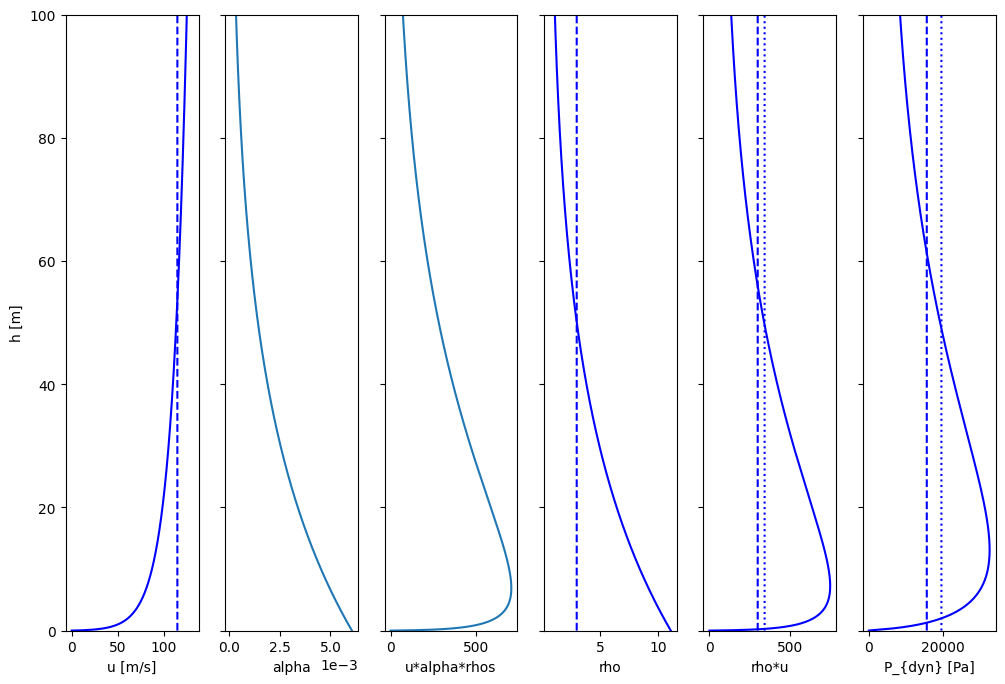

In [ ]:
ylim = 100.0

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6)

u_rel = u_coeff * sqrt(friction_coeff) / k * \
    np.log(b*np.minimum(h0, z) + 1.0)

ax1.plot(u_avg * u_rel,z,'b-')
ax1.plot(np.ones(nz+1)*u_avg,z,'b--')

ax1.set(xlabel='u [m/s]', ylabel='h [m]')

ax1.set_ylim(0, ylim)
# ax1.set_xlim(0, 145)

alpha_tot = 0

for i in range(nsolid):

    d_bl = h0
    # epsilon_s = beta_sc * u_star * d_bl / (6.0 * (k * d_bl + k_s / 10.0))
    epsilon_s = beta_sc * u_star * k * ((d_bl/6.0) + (k_s / 60.0))
    a = -(k * u_star * Pn[i]) / epsilon_s

    int_ = ((np.exp(a * h0) - 1.0) / a + np.exp(a * h0) * (h - h0)) / h

    normalizing_coeff = 1.0 / int_

    alpha_rel = normalizing_coeff * np.exp(a * (np.minimum(h0, z)))

    ualpha = ualpha + (u_avg * u_rel) * (alpha_avg[i] * alpha_rel)

    uualpha = uualpha + (u_avg * u_rel) * (u_avg * u_rel) * (alpha_avg[i] *
                                                             alpha_rel)

    alpha_tot += alpha_avg[i] * alpha_rel

    ax2.plot(alpha_avg[i] * alpha_rel, z)

    ax3.plot((u_avg * u_rel) * (alpha_avg[i] * alpha_rel) * rhos[i], z)

ax2.set(xlabel='alpha')
ax2.set_ylim(0, ylim)
# ax2.set_xlim(0, 7.4e-3)
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax2.yaxis.set_ticklabels([])

ax3.set(xlabel='u*alpha*rhos')
ax3.set_ylim(0, ylim)
# ax3.set_xlim(0,950)
ax3.yaxis.set_ticklabels([])


ax4.plot(rho, z,'b-')
ax4.plot(rhom*np.ones(nz+1),z,'b--')
ax4.set(xlabel='rho')
ax4.set_ylim(0, ylim)
# ax4.set_xlim(0,14)
ax4.yaxis.set_ticklabels([])

ax5.plot(rho * u_avg * u_rel, z,'b-')
ax5.plot(np.mean(rho * u_avg * u_rel)*np.ones(nz+1),z,'b--')
ax5.plot(np.mean(rho) * np.mean(u_avg * u_rel)*np.ones(nz+1),z,'b:')
ax5.set(xlabel='rho*u')
ax5.set_ylim(0, ylim)
# ax5.set_xlim(0, 950)
ax5.yaxis.set_ticklabels([])


ax6.plot(p_dyn, z,'b-')

p_dyn_avg1 = np.mean(p_dyn)
p_dyn_avg2 = 0.5*rhom*u_avg**2

ax6.plot(p_dyn_avg1*np.ones(nz+1), z,'b--')
ax6.plot(p_dyn_avg2*np.ones(nz+1), z,'b:')


ax6.set(xlabel='P_{dyn} [Pa]')
ax6.set_ylim(0, ylim)
# ax6.set_xlim(0, 45000)
ax6.yaxis.set_ticklabels([])

print("Averages as mean of profile values (1/n*Sum(x_i))")

print("Mean(u): ",np.mean(u_avg * u_rel))
print("Depth and solid-avergaed (u): ",np.mean(u_avg * u_rel*rho)/np.mean(rho))
print("Mean(rhom): ",np.mean(rho))
print("Mean(alpha_tot): ",np.mean(alpha_tot))
print("Mean(u*alpha_tot): ",np.mean(ualpha))
print("Mean(rhom*u): ",np.mean(rho * u_avg * u_rel))
print("Mean(rhom)*Mean(u): ", np.mean(rho) * np.mean(u_avg * u_rel))
print("Flux coefficient: ",np.mean(rho * u_avg * u_rel) /
      ( np.mean(rho) * np.mean(u_avg * u_rel) ) )

save_figure = input('Save the figure as pdf (Y/N):')
if (save_figure == "Y"):
    plt.savefig("profiles.pdf")
    files.download("profiles.pdf")

In [ ]:
# Mixture density at the bottom
rhom_bottom = sum(alphas_bottom * rhos) + (1.0 - sum(alphas_bottom)) * rhog

# Solid mass fractions (in the mixture) at the bottom
xs_bottom = (alphas_bottom * rhos) / rhom_bottom

# Gas mass fraction (in the mixture) at the bottom
xg_bottom = 1.0 - sum(xs_bottom)

# Relative solid mass fractions at the bottom (sum=1 => TGSD)
xs_rel_bottom = xs_bottom / (1.0 - xg_bottom)

# Mean size of TGSD at the bottom
mu_bottom = sum(phi * xs_rel_bottom)
print('Mean size at bottom =', mu_bottom)

Mean size at bottom = 2.0


In [ ]:
# Rates of mass lost from the flow at the bottom (propirtional to density,
# volume fraction at the bottom and settling velocity)
xs_rel_lost = (rhos * alphas_bottom * settl_vel)
# Normalization to have sum=1 (TGSD)
xs_rel_lost = (xs_rel_lost / sum(xs_rel_lost))

# Mean side of TGSD lost at the base of the flow
mu_lost = sum(phi * xs_rel_lost)

print('Mean size lost at the base of the flow = #e phi \n', mu_lost)

Mean size lost at the base of the flow = #e phi 
 2.0


Save the figure as pdf (Y/N):N


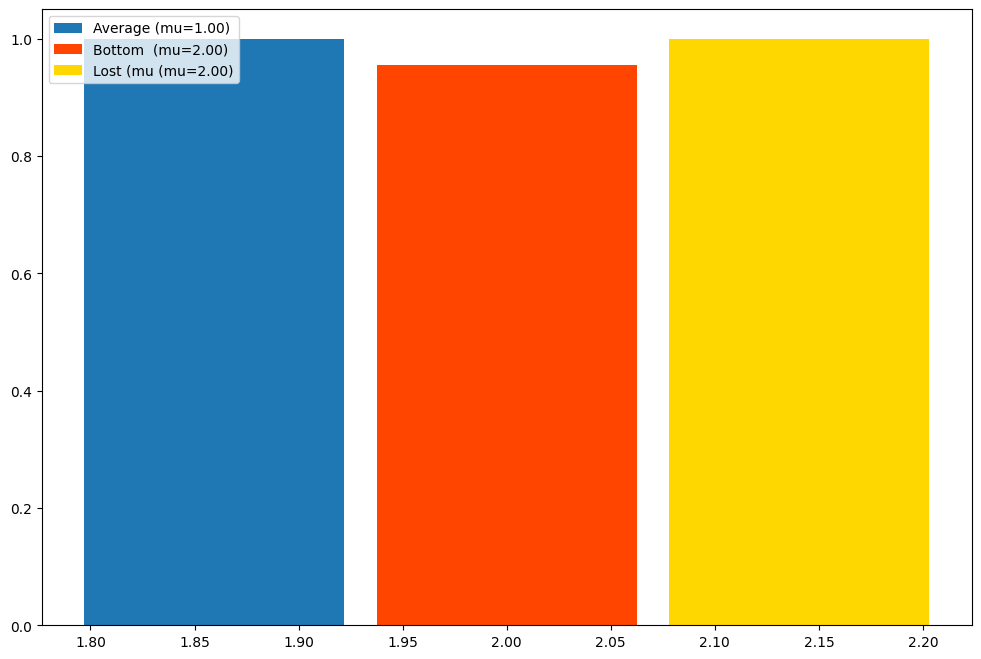

In [ ]:
fig
barwidth = 0.125

phi_avg = phi
phi_bottom = phi
phi_lost = phi

phi_avg = phi - barwidth * (1.125)
phi_bottom = phi
phi_lost = phi + barwidth * (1.125)

plt.bar(phi_avg, xs_rel, label='Average (mu=%.2f)'%mu, width=barwidth,
        color='tab:blue')
plt.bar(phi_bottom,
        xs_bottom,
        label='Bottom  (mu=%.2f)'%mu_bottom,
        width=barwidth,
        color='orangered')
plt.bar(
    phi_lost,
    xs_rel_lost,
    label='Lost (mu (mu=%.2f)'%mu_lost,
    width=barwidth,
    color='gold',
)

plt.legend(loc='upper left')

save_figure = input('Save the figure as pdf (Y/N):')
if (save_figure == "Y"):
    plt.savefig("TGSD.pdf")
    files.download("TGSD.pdf")